# Overview
For this capstone project I will be working on identifying online harassment using NLP.  Why focus on harassment?  Well, for starters, it's a problem that affects a quarter of the population in the U.S.  Additionally, according to a [2021 Pew research poll]( (https://www.pewresearch.org/internet/2021/01/13/the-state-of-online-harassment/)), 79% of respondants "say social media companies are doing an only fair or poor job at addressing online harassment or bullying on their platforms."  Our goal is to construct a virtual moderator, or vMOD, a NLP model that is capable of predicting if a comment is harassment or not, and automatically blocks users who are sending hateful comments.


"Fully 33% of women under 35 say they have been sexually harassed online", For those who identify as LBGTQA, "51% have been targeted for more severe forms of online abuse."

"Among adults who have been harassed online, roughly half of women (47%) say they think they have encountered harassment online because of their gender, whereas 18% of men who have been harassed online say the same. Similarly, about half or more Black (54%) or Hispanic online harassment targets (47%) say they were harassed due to their race or ethnicity, compared with 17% of White targets."


[Plos article](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0221152)


# Data Understanding


Our data comes from a [Kaggle competetion](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data), Identifying Toxic Comments, a dataset comprising of 159571 data points.
measures of central tendency, spread, give broad narrative of data itself.  

How we clean and preprocess our data will have a major effect on the conclusions we can draw

The Natural Language Tool Kit (NLTK) is one of the most popular Python libraries for NLP

Regular Expressions are an important part of NLP, which can be used for pattern matching and filtering

**Feature Engineering** is essential when working with text data, and to understand the dynamics of your text:
* Common feature engineering techniques are removing stop words, stemming, lemmatization, and n-grams
* When diving deeper into grammar and linguistics, context-free grammars and part-of-speech tagging is important
* In this context, parse trees can help computers when dealing with ambiguous words


Then talk about automating process using [Kaggle API key](https://www.kaggle.com/docs/api).

Per [A Literature Survey on Algorithms for Multi-label
Learning](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.364.5612&rep=rep1&type=pdf) "in multi-label classification, predictions for an instance is a set of labels and, therefore, the prediction
can be fully correct, partially correct (with different levels of correctness) or fully incorrect. None of
these existing evaluation metrics capture such notion in their original form. This makes evaluation
of a multi-label classifier more challenging than evaluation of a single label classifier."

## Import Data
In this section we'll take a preliminary look at our data to get a feel for what we're working with. Let's begin with our import statements and then by taking a look at the contents of our train data directory.

In [17]:
import sys, re, os, csv, codecs, string
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from google.colab import drive


import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Flatten, Input, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D, SpatialDropout1D, BatchNormalization
from keras.preprocessing import sequence


import shutil

import nltk
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Get current directory
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'drive', 'sample_data']


In [2]:
# Set path to xrays.  Hint- right click on the file you want to copy file path
drive_path = '/content/drive/MyDrive/Colab_Notebooks/jigsaw-toxic-comment-classification-challenge.zip'


In [3]:
# Navigate to corpus
!cp '{drive_path}' .

In [ ]:
# Get current directory/confirm correct path
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'drive', 'jigsaw-toxic-comment-classification-challenge.zip', 'sample_data']


In [4]:
# Unzip
!unzip '/content/jigsaw-toxic-comment-classification-challenge.zip'

Archive:  /content/jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [7]:
# import csv data as pd df
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip')
test_labels= pd.read_csv('test_labels.csv.zip')


## Inspect Data

In [ ]:
train.shape

(159571, 8)

In [ ]:
print("Number of Train NaN:", train['comment_text'].isnull().sum())
print("Number of Test NaN:", test['comment_text'].isnull().sum())
print("Number of Label NaN:", test_labels.isnull().sum())


Number of Train NaN: 0
Number of Test NaN: 0
Number of Label NaN: id               0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [ ]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
len = train.comment_text.len()
print("Shortest comment:", len.min(), "words")
print("Longest comment:", len.max(), "words")
print("Average comment:", len.mean().round(0), "words")




Shortest comment: 6 words
Longest comment: 5000 words
Average comment: 394.0 words


## Train, Test, Val Split

In [8]:
# Train test dataframes
Xtrain = train['comment_text'].str.lower()
ytrain = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]


In [9]:
#Train test split
X_train_1, X_test, y_train_1, y_test = train_test_split(Xtrain, ytrain,
                                                    test_size=0.15, random_state=42)


In [10]:
 # Val split *Validation data abels for the test data could not be used per Kaggle "value of -1 indicates it was not used for scoring; (Note: file added after competition close!)"
 X_train, X_val, y_train, y_val= train_test_split(X_train_1, y_train_1,
                                                    test_size=0.05, random_state=42)

In [ ]:
# Examine train test val
print("Train Comments:", X_train.head(2))
print("--------------------------------")

print("Test Comments:", X_test.head(2))
print("--------------------------------")

print("Val Comments:", X_val.head(2))
print("--------------------------------")

print("Train Target Variables:", y_train.head(2))
print("--------------------------------")

print("Test Target Variables:", y_test.head(2))
print("--------------------------------")

print("Val Target Variables:", y_val.head(2))
print("--------------------------------")


Train Comments: 159023    service award\nhello. i noticed you list yours...
76867     "\nwelcome!hello and welcome to wikipedia. tha...
Name: comment_text, dtype: object
--------------------------------
Test Comments: 119105    geez, are you forgetful!  we've already discus...
131631    carioca rfa \n\nthanks for your support on my ...
Name: comment_text, dtype: object
--------------------------------
Val Comments: 7608     "\n ok, i understand. -) i've been a racist fo...
20119    again again again \n\nthis is not going to sto...
Name: comment_text, dtype: object
--------------------------------
Train Target Variables:         toxic  severe_toxic  obscene  threat  insult  identity_hate
159023      0             0        0       0       0              0
76867       0             0        0       0       0              0
--------------------------------
Test Target Variables:         toxic  severe_toxic  obscene  threat  insult  identity_hate
119105      0             0        0       0

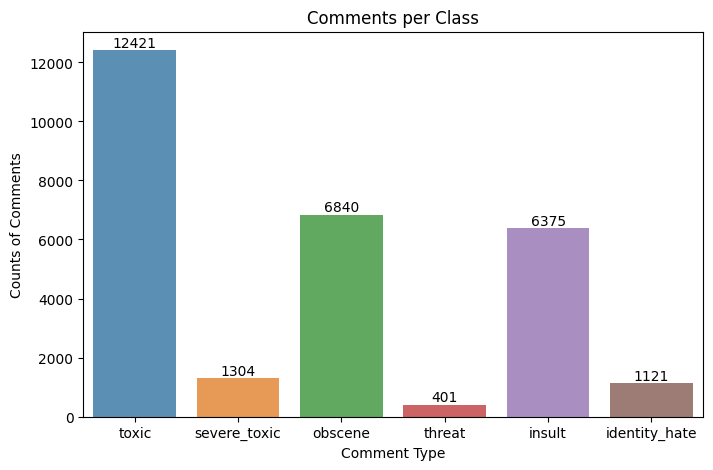

In [ ]:
cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

val_counts = y_train[cols].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(x= val_counts.index, y= val_counts.values, alpha=0.8)

plt.title("Comments per Class")
plt.xlabel("Comment Type")
plt.ylabel("Counts of Comments")

rects = ax.patches
labels = val_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha="center", va="bottom")


plt.show()

In [ ]:
# Find total number of toxic comments in train
x=train.iloc[:,2:].sum()
print("Total number of toxic comments:", x.sum())


Total number of toxic comments: 35098


### Class Imbalance
We can see there is a clear class imbalance in our data-only 35,098 comments are considered toxic, out of our dataset of 159,571; far more records have no toxic languge than do.  We'll need to take this into account when building our model.


# Data Preprocessing

We've already lowercased the letters of our corpus, and now we'll untertake our next step, tokenizing our corpus, or splitting each comment into a series of words.  We'll have to make some decisions now about whether we remove stop words, what kinds of regex expressions we should use to clean the comments, if we should stem, lemmatize, or leave our text data as is before we come to our next step, vectorization.

Because our dataset is quite large, we'll begin by removing stop words.  We'll do this because large datasets become highly dimensionsal after they've been vectorized, and to minimize processing times we'll need to reduce the amount of tokens we pass in to our vector.  Removing stop words- the most common words in english that have little value in this use case, will help us do so.

We'll also use a regex expression to clean up some of the comments.  As we could see in our datatframe, there's many examples of strange punctuation that could adversly affect our model's performance, and we'll want to edit those out as well.

We'll hold off on stemming or lemmatizing for now.  If our results from our initial models are unsatisfactory, we'll circle back to stemming our tokens.



### Clean

In [11]:
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text


    return text

In [12]:
X_train = X_train.map(lambda com : clean_text(com))
X_test = X_test.map(lambda com : clean_text(com))
X_val = X_val.map(lambda com : clean_text(com))



# Vectorization
In order to get these tokens from our documents, we're going to use tools called "vectorizers".  These convert words into numerical representations, allowing computers to build and evaluate machine learning models.  

Vectorization allows our model to:
* Find word predictions
* Find word similarities
* Represent words in a lower-dimensional space
* Allow words with similar meanings to have a similar representation
* Approximate meaning

The most straightforward vectorizer in sklearn.feature_extraction.text is the CountVectorizer, which will simply count the number of each word type in each document.  Two other strategies include:

* Bag of Words: A a simple, yet effective text encoding technique. Corpus is tokenized, only unique words are selected to create the vocabulary and then sorted by alphabetical order.  Single words or n-grams can be used for analysis.


* TF-IDF: Term Frequency–Inverse Document Frequency, is a numerical statistic that’s intended to reflect how important a word is to a document.  This is a slightly more sophisticated version of bag of words.

We'll use a pipeline to send both the CountVectorizer and TfidfTransformer vectors through a Multinomial Naive Bayes classifier, wrapping that in a MultiOutputClassifier to account for our 6 target variables.



# Bayes's Theorem
"...with NB models generally
outperforming the sophisticated, structure-sensitive
models explored in recent work. Furthermore, by
combining generative and discriminative classifiers,
we present a simple model variant where an SVM is
built over NB log-count ratios as feature values, and
show that it is a strong and robust performer over all
the presented tasks"

 Multinomial Naive Bayes (MNB) better att snippets.  Support Vector Machine (SVM) better at full length and  SVM with NB(Naive Bayes) features (NBSVM) doing well on both
[Baselines and Bigrams: Simple, Good Sentiment and Topic Classification](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf)



Build pipeline

In [18]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultiOutputClassifier(MultinomialNB())),
               ])
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=y_test.columns))



accuracy 0.9014872994652406
               precision    recall  f1-score   support

        toxic       0.99      0.18      0.30      2260
 severe_toxic       0.00      0.00      0.00       225
      obscene       0.99      0.11      0.21      1279
       threat       1.00      0.02      0.04        53
       insult       0.98      0.05      0.10      1192
identity_hate       0.00      0.00      0.00       227

    micro avg       0.99      0.12      0.21      5236
    macro avg       0.66      0.06      0.11      5236
 weighted avg       0.90      0.12      0.20      5236
  samples avg       0.02      0.01      0.01      5236



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


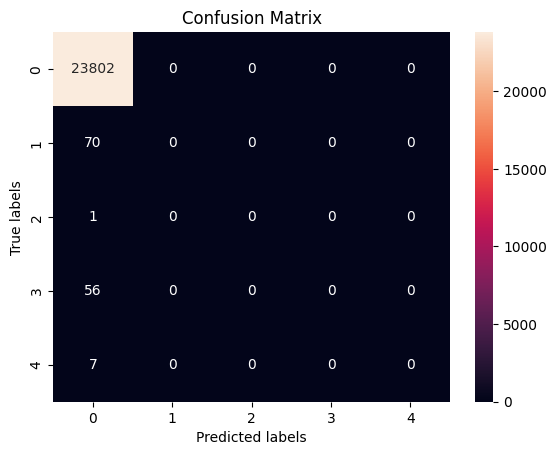

In [22]:
lables = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_pred = np.argmax(nb.predict(X_test), axis=1)
thresh = 0.5
y_pred = (y_pred > thresh)

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, label=lables);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');



Precision Measures the accuracy of positive predictions. It quantifies the number of positive class predictions that actually belong to the positive class. We had a very small percentage of false positives, only 1%


Recall Measures the completeness of positive predictions. It quantifies the number of positive class predictions made out of all positive examples in the dataset.  The recall of our model was very poor, only 12%  of our total positives were captured.

F1 scores are the harmonic mean of precision and recall, and often is more accurate than looking solely at precision.  From our F1 scores of 30%, we can see that we're doing a poor job using a multioutput model.  Let's see if switching it to a binary output helps to improve our ability to identify toxic speech.


## Binary target
We'll try exactly the same preprocessing with exactly the same model, but with a binary target below

In [33]:


cols=['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
train['Toxic']=train[cols].max(axis=1).apply(lambda x: 1 if x ==1 else 0)

In [34]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,1
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,0


In [35]:
# Train test dataframes
Xtrain = train['comment_text'].str.lower()
ytrain = train['Toxic']


In [36]:
#Train test split
X_train_1, X_test_bi, y_train_1, y_test_bi = train_test_split(Xtrain, ytrain,
                                                    test_size=0.15, random_state=42)


In [37]:
 # Val split *Validation data abels for the test data could not be used per Kaggle "value of -1 indicates it was not used for scoring; (Note: file added after competition close!)"
 X_train_bi, X_val_bi, y_train_bi, y_val_bi= train_test_split(X_train_1, y_train_1,
                                                    test_size=0.05, random_state=42)

In [38]:
X_train_bi = X_train_bi.map(lambda com : clean_text(com))
X_test_bi = X_test_bi.map(lambda com : clean_text(com))
X_val_bi = X_val_bi.map(lambda com : clean_text(com))

In [40]:
nb2 = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
               ])
nb2.fit(X_train_bi, y_train_bi)

y_pred_bi = nb2.predict(X_test_bi)

print('accuracy %s' % accuracy_score(y_pred_bi, y_test_bi))
print(classification_report(y_test_bi, y_pred_bi))

accuracy 0.9201620989304813
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     21542
           1       0.99      0.20      0.34      2394

    accuracy                           0.92     23936
   macro avg       0.96      0.60      0.65     23936
weighted avg       0.93      0.92      0.90     23936



#  Model Using Embeddings
 need to dissect and rewrite in my own code

```
# This is formatted as code
```



In [ ]:
# Set parameters:
max_features = 50000
maxlen = 5000
batch_size = 32
embedding_dims = 64
epochs = 4

In [ ]:
comment_input = Input((maxlen,))

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
comment_emb = Embedding(max_features, embedding_dims, input_length=maxlen)(comment_input)

# we add a GlobalMaxPool1D, which will extract information from the embeddings
# of all words in the document
comment_emb = SpatialDropout1D(0.25)(comment_emb)
max_emb = GlobalMaxPool1D()(comment_emb)

# normalized dense layer followed by dropout
main = BatchNormalization()(max_emb)
main = Dense(64)(main)
main = Dropout(0.5)(main)

# We project onto a six-unit output layer, and squash it with sigmoids:
output = Dense(6, activation='sigmoid')(main)

model = Model(inputs=comment_input, outputs=output)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Build model...


In [ ]:
model_history = model.fit(X_train,
                          X_test,
                          batch_size=100,
                          epochs=5,
                          validation_data=(y_train, y_test))


In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Making things BERT friendly
BERT, which stands for Bidirectional Encoder Representations from Transformers

First let's make the data compliant with BERT:

Column 0: An ID for the row. (Required both for train and test data.)
Column 1: The class label for the row. (Required only for train data.)
Column 2: A column of the same letter for all rows — this is a throw-away column that we need to include because BERT expects it. (Required only for train data.)
Column 3: The text examples we want to classify. (Required both for train and test data.)

We need to split the files into the format expected by BERT: BERT comes with data loading classes that expects two files called train and dev for training. In addition, BERT’s data loading classes can also use a test file but it expects the test file to be unlabelled.


Once the data is in the correct format, we need to save the files as .tsv (BERT doesn't take .csv as input.)



In [ ]:
# A dependency of the preprocessing for BERT inputs
pip install -U "tensorflow-text==2.13.*"

In [ ]:
pip install "tf-models-official==2.13.*"

In [ ]:
# Creating training dataframe according to BERT by adding the required columns
df_bert = pd.DataFrame({
    'id':range(len(train_df)),
    'label':train_df[0],
    'alpha':['a']*train_df.shape[0],
    'text': train_df[1].replace(r'\n', ' ', regex=True)
})

In [ ]:
# Saving dataframes to .tsv format as required by BERT
df_bert_train.to_csv('data/train.tsv', sep='\t', index=False, header=False)
df_bert_dev.to_csv('data/dev.tsv', sep='\t', index=False, header=False)
df_bert_test.to_csv('data/test.tsv', sep='\t', index=False, header=False)

3. Training Model using Pre-trained BERT model
Some checkpoints before proceeding further:

All the .tsv files should be in a folder called “data” in the “BERT directory”.
We should have created a folder “bert_output” where the fine tuned model will be saved.
The pre-trained BERT model should have been saved in the “BERT directory”.
The paths in the command are relative path, “./”
Now, navigate to the directory you cloned BERT into and type the following command:



In [ ]:
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/4
3624/3624 [==============================] - 62s 17ms/step - loss: 0.1014 - accuracy: 0.7893 - val_loss: 0.0566 - val_accuracy: 0.9943
Epoch 2/4
3624/3624 [==============================] - 61s 17ms/step - loss: 0.0616 - accuracy: 0.8429 - val_loss: 0.0542 - val_accuracy: 0.9924
Epoch 3/4
3624/3624 [==============================] - 60s 17ms/step - loss: 0.0551 - accuracy: 0.7719 - val_loss: 0.0525 - val_accuracy: 0.9923
Epoch 4/4
3624/3624 [==============================] - 61s 17ms/step - loss: 0.0514 - accuracy: 0.7318 - val_loss: 0.0515 - val_accuracy: 0.9936
